# Autogen: Coding and Financial Analysis

## Installation

In [1]:
! pip install huggify-data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [1]:
! pip install pyautogen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00


## Setup

In [2]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

In [3]:
llm_config = {"model": "gpt-4-turbo", "api_key": api_key}

## Define a code executor

## User-Defined Functions

Instead of asking LLM to generate the code for downloading stock data
and plotting charts each time, you can define functions for these two tasks and have LLM call these functions in the code.

In [61]:
def get_df_from_pdf(pdf_path):
    """Get the stock prices for the given stock symbols extracted from a PDF file using Huggify's PDFQnAGenerator.

    Args:
        pdf_path (str): The path to the PDF file containing stock data.

    Returns:
        pandas.DataFrame: A DataFrame with the stock prices for the given stock symbols indexed by date,
        with one column per stock symbol.
    """

    from huggify_data.scrape_modules import PDFQnAGenerator
    from google.colab import userdata

    # pdf_path = "/content/all_ysa_doc.pdf"
    openai_api_key = "sk-xxx" # userdata.get('OPENAI_API_KEY')
    generator = PDFQnAGenerator(pdf_path, openai_api_key)
    generator.process_scraped_content()
    generator.generate_questions_answers()
    df = generator.convert_to_dataframe()

    return df

In [63]:
def acquire_response_from_csv(current_prompt):
    """Acquire response from a AI chatbot based on the given prompt using RAG model.

    This function interacts with an AI chatbot to generate a response based on the provided current prompt.

    Args:
        current_prompt (str): The prompt for generating the response from the chatbot.

    Returns:
        str: The response generated by the chatbot based on the provided prompt.
    """

    from huggify_data.bot_modules import ChatBot

    openai_api_key = "sk-xxx" # userdata.get('OPENAI_API_KEY')
    chatbot = ChatBot(api_key=openai_api_key)

    current_prompt = "What is the main purpose of YSA?"
    response = chatbot.run_rag(openai_api_key, current_prompt, df, top_n=2)

    return response

### Define Agent

In [64]:
from autogen import ConversableAgent, AssistantAgent

In [65]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [66]:
code_writer_agent_system_message = code_writer_agent.system_message
# print(code_writer_agent_system_message)

### Create a new executor with the user-defined functions

In [67]:
from autogen.coding import LocalCommandLineCodeExecutor

**Note**: The agent will automatically save the code in a .py file and the plot in a .png file. To access and check the files generated by the agents, go to the `File` menu and select `Open....` Then, open the folder named `coding` to find all the generated files.

In [68]:
executor = LocalCommandLineCodeExecutor(
    timeout=120,
    work_dir="coding",
    functions=[get_df_from_pdf, acquire_response_from_csv],
)

In [69]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

### Let's update the agents with the new system message

In [70]:
code_writer_agent_system_message

'You are a helpful AI assistant.\nSolve tasks using your coding and language skills.\nIn the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.\n    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.\n    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.\nSolve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.\nWhen using code, you must indicate the script type in the code block. The user cannot provide any oth

In [71]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="ALWAYS",
)

In [72]:
executor.functions

[<function __main__.get_df_from_pdf(pdf_path)>,
 <function __main__.acquire_response_from_csv(current_prompt)>]

In [73]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="NEVER",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### Start the same task again!

In [74]:
import datetime

today = datetime.datetime.now().date()
print(today)

2024-08-03


In [75]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=input("Enter here: ")
)

Enter here: I have a book in this directory: /content/the-great-gatsby-small.pdf. I want to create df from pdf. 
code_executor_agent (to code_writer_agent):

I have a book in this directory: /content/the-great-gatsby-small.pdf. I want to create df from pdf. 

--------------------------------------------------------------------------------
Replying as code_writer_agent. Provide feedback to code_executor_agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

To extract the data from your PDF document and convert it into a DataFrame, I'll use the `get_df_from_pdf` function provided. This function will read the PDF file located at `/content/the-great-gatsby-small.pdf` and convert its contents into a DataFrame format, assuming that the file contains structured data suitable for this operation.

Let's proceed with extracting the data:

```python
# fil

### Plot the results

In [ ]:
import os
from IPython.display import Image

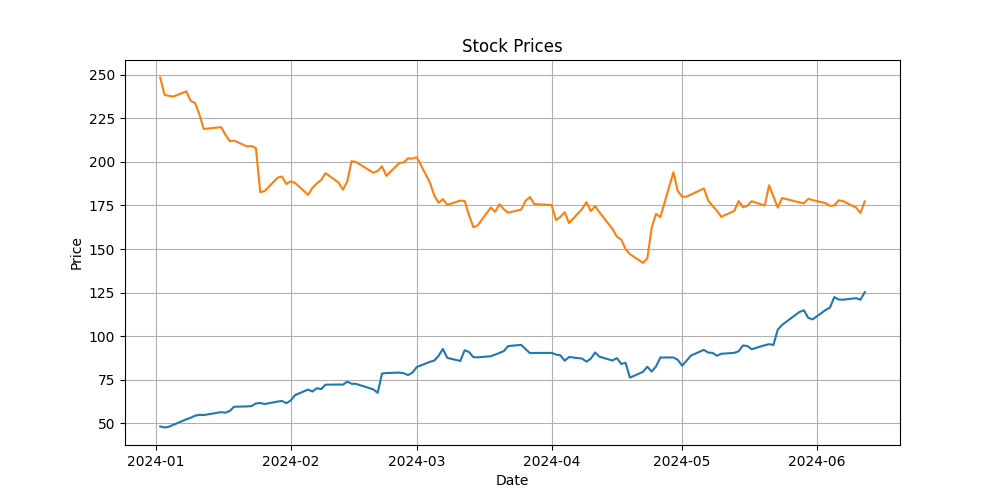

In [ ]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))

**Note**: The agent will automatically save the code in a .py file and the plot in a .png file. To access and check the files generated by the agents, go to the `File` menu and select `Open....` Then, open the folder named `coding` to find all the generated files.

## Execute as `run.py` Script

To run the following python script, you'll need to create a `requirements.txt` file with the following libraries.

```txt
yfinance
openai
pyautogen
```

Then you can create a `run.py` python script with the following code. You can use it to execute in a terminal window, i.e. `python run.py`.

```py
import yfinance
import matplotlib.pyplot as plt
from autogen import ConversableAgent, AssistantAgent
from autogen.coding import LocalCommandLineCodeExecutor
import datetime
import os


from google.colab import userdata
api_key = "sk-xxx"


# Define functions
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

# Setup agents
llm_config = {"model": "gpt-4-turbo", "api_key": api_key} # Replace with your actual model configuration

code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

code_writer_agent_system_message = code_writer_agent.system_message

executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

code_writer_agent_system_message += executor.format_functions_for_prompt()

code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="ALWAYS",
)

code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply="Please continue. If everything is done, reply 'TERMINATE'.",
)

# Get today's date
today = datetime.datetime.now().date()
print(today)

# Initiate chat
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Download the stock prices YTD for NVDA and TSLA and create a plot. Make sure the code is in a markdown code block and save the figure to a file stock_prices_YTD_plot.png."
)

# Display the generated plot
plot_path = os.path.join("coding", "stock_prices_YTD_plot.png")
if os.path.exists(plot_path):
    from PIL import Image
    img = Image.open(plot_path)
    img.show()
else:
    print("Plot not found. Ensure the script has executed correctly and the file path is correct.")

```